In [1]:
# General imports
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.table import Table

# DC2 catalog-related imports
import FoFCatalogMatching
import GCRCatalogs
from GCR import GCRQuery

#import clmm
#CLMM imports
#try: import clmm
#except:
#    import notebook_install
#    notebook_install.install_clmm_pipeline(upgrade=False)
#    import clmm

import mysql
from mysql.connector import Error

In [2]:
%%time
#extragalactic_cat = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_small',)
extragalactic_cat = GCRCatalogs.load_catalog('cosmoDC2',)

CPU times: user 661 ms, sys: 161 ms, total: 822 ms
Wall time: 2.22 s


In [6]:
%%time
len(extragalactic_cat)

CPU times: user 2.86 s, sys: 7.99 s, total: 10.8 s
Wall time: 2min 18s


2256249331

In [9]:
%%time
# get list of massive halos in a given redshift and mass range
mmin = 5.e14 #Msun
zmax = 2.0

massive_halos = extragalactic_cat.get_quantities(['halo_mass','hostHaloMass','redshift','ra', 'dec', 'halo_id'],\
                                                 filters=[f'halo_mass > {mmin}','is_central==True',
                                                          f'redshift<{zmax}'])

N_cl = len(massive_halos['halo_mass'])
print(f'There are {N_cl} clusters in that mass and redshift ranges')

There are 147 clusters in that mass and redshift ranges
CPU times: user 15.1 s, sys: 50 s, total: 1min 5s
Wall time: 6min 25s


In [7]:
%%time
# Selecting the most massive one
select = massive_halos['halo_mass'] == np.max(massive_halos['halo_mass'])
ra_cl = massive_halos['ra'][select][0]
dec_cl = massive_halos['dec'][select][0]
z_cl = massive_halos['redshift'][select][0]
mass_cl =massive_halos['halo_mass'][select][0]
id_cl = massive_halos['halo_id'][select][0]

print (f'The most massive cluster is halo {id_cl}, in ra = {ra_cl:.2f} deg, dec = {dec_cl:.2f} deg, z = {z_cl:.2f}, with mass = {mass_cl:.2e} Msun')

The most massive cluster is halo 135700142421, in ra = 63.29 deg, dec = -39.65 deg, z = 0.19, with mass = 1.24e+15 Msun
CPU times: user 918 µs, sys: 0 ns, total: 918 µs
Wall time: 755 µs


In [27]:
%%time
# Coordinate filter to be applied applied to both extragalactic and object catalog
ra_min, ra_max = ra_cl-0.35, ra_cl+0.35
dec_min, dec_max = dec_cl-0.35, dec_cl+0.35

coord_filters = [
    f'ra >= {ra_min}',
    f'ra < {ra_max}',
    f'dec >= {dec_min}',
    f'dec < {dec_max}',
]

# Redshift cut to be applied to the extragalactic catalog. The object catalog does not have redshift information.
z_min = z_cl + 0.1
redshift_filters = [
    (np.isfinite, 'redshift'),
    f'redshift > {z_min}',
]

# Magnitude cut to be applied to both catalogs
mag_filters = [
    (np.isfinite, 'mag_i'),
    'mag_i < 24.5',
]

# Following DC2 tutorials, basics cuts to be applied to the object catalog
object_basic_cuts = [
    GCRQuery('extendedness > 0'),     # Extended objects
    GCRQuery((np.isfinite, 'mag_i')), # Select objects that have i-band magnitudes
    GCRQuery('clean'), # The source has no flagged pixels (interpolated, saturated, edge, clipped...) 
                       # and was not skipped by the deblender
    GCRQuery('xy_flag == 0'),                                      # Flag for centroid measurement (0 if OK)
    GCRQuery('ext_shapeHSM_HsmShapeRegauss_flag == 0'),            # Flag returned by shape measurement code (0 if OK)
    GCRQuery((np.isfinite, 'ext_shapeHSM_HsmShapeRegauss_sigma')), # Shape measurement uncertainty should not be NaN
]

# Adding the total ellipticity quantity to the object catalog
#object_cat.add_quantity_modifier('shape_hsm_regauss_etot', 
#                                 (np.hypot, 'ext_shapeHSM_HsmShapeRegauss_e1', 'ext_shapeHSM_HsmShapeRegauss_e2'), 
#                                 overwrite=True)

# Following DC2 tutorials, additional WL quality cuts to be applied to the object catalog
object_properties_cuts = [
    GCRQuery('snr_i_cModel > 10'),                              # SNR > 10
    GCRQuery('mag_i_cModel < 24.5'),                            # cModel imag brighter than 24.5
    GCRQuery('ext_shapeHSM_HsmShapeRegauss_resolution >= 0.3'), # Sufficiently resolved galaxies compared to PSF
    GCRQuery('shape_hsm_regauss_etot < 2'),                     # Total distortion in reasonable range
    GCRQuery('ext_shapeHSM_HsmShapeRegauss_sigma <= 0.4'),      # Shape measurement errors reasonable
    GCRQuery('blendedness < 10**(-0.375)')                      # Avoid spurious detections and those contaminated by blends
]

CPU times: user 1.59 ms, sys: 69 µs, total: 1.66 ms
Wall time: 1.34 ms


In [9]:
%%time
extragal_data = extragalactic_cat.get_quantities(['ra', 'dec', 'shear_1', 'shear_2', 
                                                  'ellipticity_1_true', 'ellipticity_2_true',
                                                  'redshift', 'convergence', 'galaxy_id'], 
                                                 filters=(coord_filters + mag_filters + redshift_filters))

CPU times: user 6min 52s, sys: 2min 39s, total: 9min 32s
Wall time: 11min 23s


In [23]:
print(ra_cl, dec_cl, len(extragal_data['redshift']))
print(ra_min, ra_max, dec_min, dec_max)

63.28980748965139 -39.647126899140524 34730
62.939807489651386 63.63980748965139 -39.997126899140525 -39.29712689914052


In [14]:
extragal_data['dec']

array([-39.94342781, -39.91524376, -39.96504485, ..., -39.65518951,
       -39.44562887, -39.32961455])

In [28]:
query_good  = 'AND dref.base_PixelFlags_flag_edge = 0 '
query_good += 'AND dref.base_PixelFlags_flag_interpolatedCenter = 0 '
query_good += 'AND dref.base_PixelFlags_flag_saturatedCenter = 0 '
query_good += 'AND dref.base_PixelFlags_flag_crCenter = 0 '
query_good += 'AND dref.base_PixelFlags_flag_bad = 0 '
query_good += 'AND dref.base_PixelFlags_flag_suspectCenter = 0 '
query_good += 'AND dref.base_PixelFlags_flag_clipped = 0 '

query_clean = query_good + 'AND dref.deblend_skipped =0 '

dc2_object_run2_2i_dr6_wfd

In [31]:
query =  "SELECT dref.coord_ra as ra, dref.coord_dec as dec, dref.ext_shapeHSM_HsmShapeRegauss_e1, "
query += "dref.ext_shapeHSM_HsmShapeRegauss_e2, dref.objectId as id, dfrc.i_modelfit_CModel_instFlux "
query += "FROM dc2_object_run2_2i_dr6_wfd.dpdd_ref as dref, dc2_object_run2_2i_dr6_wfd.position as dpos, dc2_object_run2_2i_dr6_wfd.dpdd_forced as dfrc "
query += f"WHERE scisql_s2PtInBox(coord_ra, coord_dec, {ra_min}, {dec_min}, {ra_max}, {dec_max}) = 1 "
query += "AND dref.objectId = dpos.objectId AND dfrc.objectId = dpos.objectId "
query += "AND dpos.detect_isPrimary = 1 "
query += query_clean
query += "AND dref.base_SdssCentroid_flag = 0 "
query += "AND dref.base_Blendedness_abs < POWER(10, -0.375) "
query += "AND dref.base_Blendedness_abs_instFlux IS NULL "
query += "AND dref.base_ClassificationExtendedness_flag = 0 AND dref. base_ClassificationExtendedness_value > 0 "
query += "AND dfrc.i_modelfit_CModel_flag = 0 AND dfrc.i_modelfit_CModel_instFlux > 0 "
query += "AND dfrc.i_modelfit_CModel_instFlux/dfrc.i_modelfit_CModel_instFluxErr > 10 "
query += "AND dref.ext_shapeHSM_HsmShapeRegauss_resolution >= 0.3 "
query += "AND dref.ext_shapeHSM_HsmShapeRegauss_sigma <= 0.4 "
query += "AND SQRT(POWER(dref.ext_shapeHSM_HsmShapeRegauss_e1, 2)+POWER(dref.ext_shapeHSM_HsmShapeRegauss_e2, 2)) < 2 "
#query += "LIMIT 10 "
query += ";"

query

'SELECT dref.coord_ra as ra, dref.coord_dec as dec, dref.ext_shapeHSM_HsmShapeRegauss_e1, dref.ext_shapeHSM_HsmShapeRegauss_e2, dref.objectId as id, dfrc.i_modelfit_CModel_instFlux FROM dc2_object_run2_2i_dr6_wfd.dpdd_ref as dref, dc2_object_run2_2i_dr6_wfd.position as dpos, dc2_object_run2_2i_dr6_wfd.dpdd_forced as dfrc WHERE scisql_s2PtInBox(coord_ra, coord_dec, 62.939807489651386, -39.997126899140525, 63.63980748965139, -39.29712689914052) = 1 AND dref.objectId = dpos.objectId AND dfrc.objectId = dpos.objectId AND dpos.detect_isPrimary = 1 AND dref.base_PixelFlags_flag_edge = 0 AND dref.base_PixelFlags_flag_interpolatedCenter = 0 AND dref.base_PixelFlags_flag_saturatedCenter = 0 AND dref.base_PixelFlags_flag_crCenter = 0 AND dref.base_PixelFlags_flag_bad = 0 AND dref.base_PixelFlags_flag_suspectCenter = 0 AND dref.base_PixelFlags_flag_clipped = 0 AND dref.deblend_skipped =0 AND dref.base_SdssCentroid_flag = 0 AND dref.base_Blendedness_abs < POWER(10, -0.375) AND dref.base_Blendednes

In [32]:
%%time
cursor.execute(query)
res = cursor.fetchall()

CPU times: user 522 ms, sys: 78.5 ms, total: 601 ms
Wall time: 1.48 s


In [20]:
from GCRCatalogs import dc2_object
import numpy as np

v = {k: np.array([dic[k] for dic in res]) for k in res[0]}
v['mag_i_cModel'] =  dc2_object.convert_dm_ref_zp_flux_to_mag(v['i_modelfit_CModel_instFlux'])
cutMag = v['mag_i_cModel'] < 24.5
object_data = {k: v[k][cutMag] for k in v.keys()}

In [21]:
print(len(v['ra']), len(object_data['ra']))

36377 28054


In [22]:
%%time
results = FoFCatalogMatching.match(
    catalog_dict={'extragal': extragal_data, 'object': object_data},
    linking_lengths=1.,
    catalog_len_getter=lambda x: len(x['ra']),
)

# identify which rows are from the extragalactic catalog and which are from the object
extragal_mask = results['catalog_key'] == 'extragal'
object_mask = ~extragal_mask

# np.bincount will give up the number of id occurrences (like histogram but with integer input)
n_groups = results['group_id'].max() + 1
n_extragal = np.bincount(results['group_id'][extragal_mask], minlength=n_groups)
n_object = np.bincount(results['group_id'][object_mask], minlength=n_groups)

CPU times: user 5.91 s, sys: 56.3 ms, total: 5.97 s
Wall time: 6.05 s


In [15]:
%%time
one_to_one_group_mask = np.in1d(results['group_id'], np.flatnonzero((n_extragal == 1) & (n_object == 1)))

# Row indices in the *original* extragal/object catalogs for those 1-to-1 groups
extragal_idx = results['row_index'][one_to_one_group_mask & extragal_mask]
object_idx = results['row_index'][one_to_one_group_mask & object_mask]
print(f'Number of 1-to-1 matched objects: {len(extragal_idx)}, {len(object_idx)}')

Number of 1-to-1 matched objects: 15000, 15000
CPU times: user 7.76 ms, sys: 0 ns, total: 7.76 ms
Wall time: 6.96 ms


In [16]:
%%time
e1, e2 = clmm.utils.convert_shapes_to_epsilon(extragal_data['shear_1'][extragal_idx],extragal_data['shear_2'][extragal_idx],
                                              shape_definition='shear',kappa=extragal_data['convergence'][extragal_idx])

# Create the background galaxy catalog as a CLMM GCData (= astropy table)
dat = clmm.GCData([extragal_data['ra'][extragal_idx],extragal_data['dec'][extragal_idx],e1,
      e2,extragal_data['redshift'][extragal_idx],extragal_data['galaxy_id'][extragal_idx]], 
      names=('ra','dec', 'e1', 'e2', 'z','id'))

# Instantiate a CLMM cluster object and save it for later use.
cl_from_cosmoDC2 = clmm.GalaxyCluster(str(id_cl), ra_cl, dec_cl, z_cl, dat)   
cl_from_cosmoDC2.save('cosmoDC2_GC_qserv.pkl')

CPU times: user 7.24 ms, sys: 0 ns, total: 7.24 ms
Wall time: 15.2 ms


In [17]:
%%time
e1, e2 = clmm.utils.convert_shapes_to_epsilon(object_data['ext_shapeHSM_HsmShapeRegauss_e1'][object_idx],
                                              object_data['ext_shapeHSM_HsmShapeRegauss_e2'][object_idx],
                                              shape_definition='chi')

# The conversion may create NaN, so avoid these by creating a mask
mask = np.isfinite(e1)

CPU times: user 2.43 ms, sys: 0 ns, total: 2.43 ms
Wall time: 1.91 ms


/sps/lsst/data/boutigny/desc/mydesc_3/lib/python3.7/site-packages/clmm/utils.py:229: RuntimeWarning: invalid value encountered in sqrt
  chi_to_eps_conversion = 1./(1.+(1-(shape_1**2 + shape_2**2))**0.5)


In [18]:
%%time
# Create the background galaxy catalog as a CLMM GCData (= astropy table)
dat = clmm.GCData([object_data['ra'][object_idx][mask],object_data['dec'][object_idx][mask],
             e1[mask],
             e2[mask],
             extragal_data['redshift'][extragal_idx][mask],
             object_data['id'][object_idx][mask]], 
            names=('ra','dec', 'e1', 'e2', 'z','id'), masked=True)


# Create the background galaxy catalog as astropy table and save it for later use
cl_from_objectDC2 = clmm.GalaxyCluster(str(id_cl), ra_cl, dec_cl, z_cl, dat)  
cl_from_objectDC2.save('objectDC2_GC_qserv.pkl')

CPU times: user 3.74 ms, sys: 2.1 ms, total: 5.84 ms
Wall time: 13.8 ms


In [19]:
%%time
cl_from_objectDC2 = clmm.GalaxyCluster.load('objectDC2_GC_qserv.pkl')
cl_from_cosmoDC2 = clmm.GalaxyCluster.load('cosmoDC2_GC_qserv.pkl')

CPU times: user 6.38 ms, sys: 1.76 ms, total: 8.15 ms
Wall time: 14 ms


In [20]:
%%time
cosmo = extragalactic_cat.cosmology
bin_edges = clmm.polaraveraging.make_bins(0.15, 4, 10, method='evenlog10width')

cl_from_cosmoDC2.compute_tangential_and_cross_components(geometry="flat")
#cl_from_cosmoDC2.compute_shear(geometry="flat")
profile_from_cosmoDC2 = cl_from_cosmoDC2.make_binned_profile("radians", "Mpc", bins=bin_edges,cosmo=cosmo)
#profile_from_cosmoDC2 = cl_from_cosmoDC2.make_shear_profile("radians", "Mpc", bins=bin_edges,cosmo=cosmo)

cl_from_objectDC2.compute_tangential_and_cross_components(geometry="flat")
#cl_from_objectDC2.compute_shear(geometry="flat")
profile_from_objectDC2 = cl_from_objectDC2.make_binned_profile("radians", "Mpc", bins=bin_edges,cosmo=cosmo)
#profile_from_objectDC2 = cl_from_objectDC2.make_shear_profile("radians", "Mpc", bins=bin_edges,cosmo=cosmo)

CPU times: user 778 ms, sys: 0 ns, total: 778 ms
Wall time: 776 ms


In [21]:
%%time
es1 = extragal_data['ellipticity_1_true']
es2 = extragal_data['ellipticity_2_true']
gamma1 = extragal_data['shear_1']
gamma2 = extragal_data['shear_2']
kappa = extragal_data['convergence']

extragal_data['ellipticity_1'] = clmm.utils.compute_lensed_ellipticity(es1, es2, gamma1, gamma2, kappa)[0]
extragal_data['ellipticity_2'] = clmm.utils.compute_lensed_ellipticity(es1, es2, gamma1, gamma2, kappa)[1]

CPU times: user 7.46 ms, sys: 3.75 ms, total: 11.2 ms
Wall time: 55.3 ms


In [22]:
dat = clmm.GCData([extragal_data['ra'][extragal_idx],extragal_data['dec'][extragal_idx],
             extragal_data['ellipticity_1'][extragal_idx],
             extragal_data['ellipticity_2'][extragal_idx],
             extragal_data['redshift'][extragal_idx],
             extragal_data['galaxy_id'][extragal_idx]],
            names=('ra','dec', 'e1', 'e2', 'z','id'))

cl_from_cosmoDC2_with_e1e2 = clmm.GalaxyCluster(str(id_cl), ra_cl, dec_cl, z_cl, dat) 

In [23]:
cl_from_cosmoDC2_with_e1e2.compute_tangential_and_cross_components(geometry="flat")
profile_from_cosmoDC2_with_e1e2 = cl_from_cosmoDC2_with_e1e2.make_binned_profile("radians", "Mpc", bins=bin_edges,cosmo=cosmo)

(0.002, 0.3)

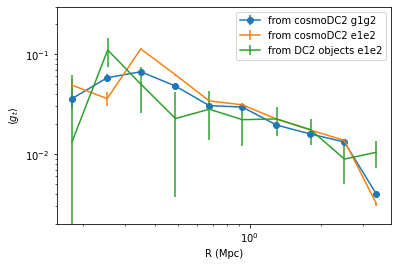

In [24]:
plt.errorbar(profile_from_cosmoDC2['radius'],profile_from_cosmoDC2['gt'],profile_from_cosmoDC2['gt_err'], 
             marker='o',label='from cosmoDC2 g1g2')
plt.errorbar(profile_from_cosmoDC2_with_e1e2['radius'],profile_from_cosmoDC2_with_e1e2['gt'],
             profile_from_cosmoDC2['gt_err'],label='from cosmoDC2 e1e2')
plt.errorbar(profile_from_objectDC2['radius'],profile_from_objectDC2['gt'],profile_from_objectDC2['gt_err'], 
             label='from DC2 objects e1e2')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('R (Mpc)')
plt.ylabel(r'$\langle g_t \rangle$')
plt.ylim([2.e-3,0.3])

Text(0.5, 1.0, 'Number of galaxies in each bin')

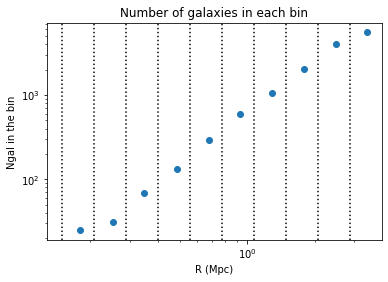

In [25]:
plt.scatter(profile_from_cosmoDC2['radius'], profile_from_cosmoDC2['n_src'], marker='o')
[plt.axvline(x=r, ymin=0, ymax=1e3, color='k', linestyle=':') for r in profile_from_cosmoDC2['radius_min']]
plt.ylabel('Ngal in the bin')
plt.xlabel('R (Mpc)')
plt.xscale('log')
plt.yscale('log')
plt.title('Number of galaxies in each bin')